In [11]:
from Bayesian_NN import construct_nn, sample_posterior_predictive
from data_info import MAPPINGS, CONTINUOUS, CATEGORICAL

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import pytensor
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score

floatX = pytensor.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [12]:
data = pd.read_csv('Flood Data.csv')
data = data.loc[:,'HAZARD 1 IN 1000':]
Y = data['HAZARD 1 IN 1000']
X = data.iloc[:,1:]

X = X.astype(floatX)
Y = Y.astype(floatX)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

print("\nNaN's per Feature:")
print(X.isna().sum()) # NaN counts

print("\nPre-Cleaning Label Distributions:")
print((Y.value_counts(normalize=True) * 100).round(2)) # label split

nan_rows = X.isna().any(axis=1).sum()
print(f"\nRows to remove: {nan_rows} of {len(X)} ({(nan_rows/len(X) * 100).round(2)}%)")
X = X.dropna()
Y = Y.loc[X.index]

print("\nPost-Cleaning Label Distributions:")
print((Y.value_counts(normalize=True) * 100).round(2)) # label split



NaN's per Feature:
ELEVATION             797
SLOPE                 998
LANDUSE               866
IMPERVIOUSNESS        678
SOIL TYPE             748
SUBSTRATE             748
NDVI                  905
DISTANCE TO RIVER    1012
BUILDING TYPE         793
DISTANCE TO ROAD     1012
dtype: int64

Pre-Cleaning Label Distributions:
HAZARD 1 IN 1000
0.0    93.34
1.0     3.06
2.0     1.87
3.0     1.53
4.0     0.19
Name: proportion, dtype: float64

Rows to remove: 1802 of 67330 (2.68%)

Post-Cleaning Label Distributions:
HAZARD 1 IN 1000
0.0    93.25
1.0     3.12
2.0     1.90
3.0     1.55
4.0     0.18
Name: proportion, dtype: float64


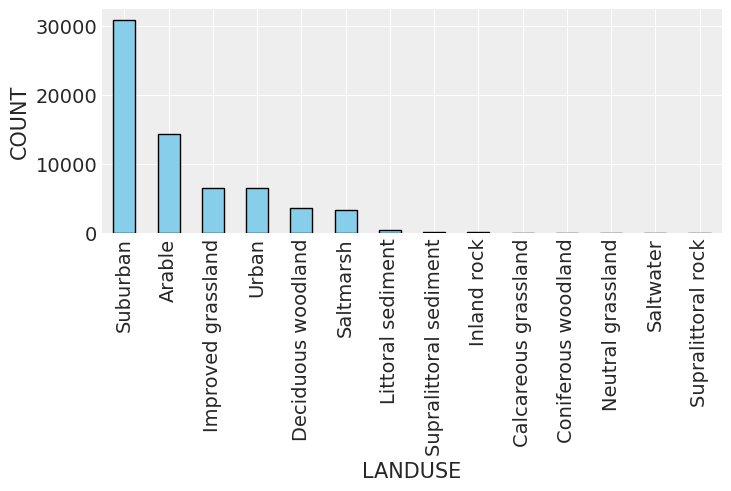

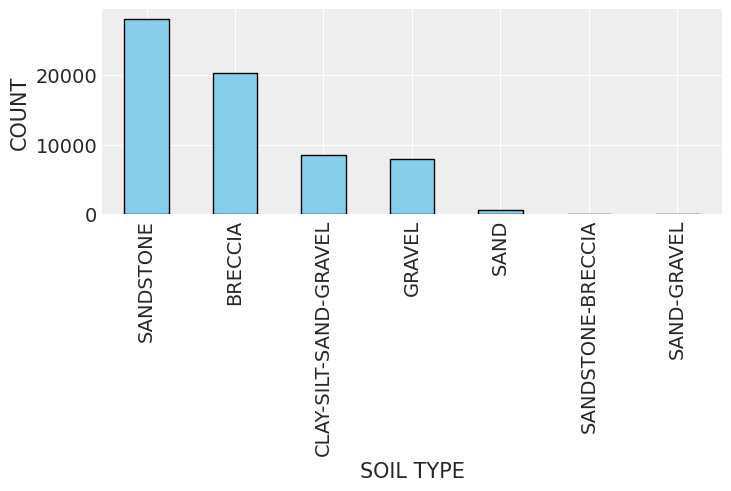

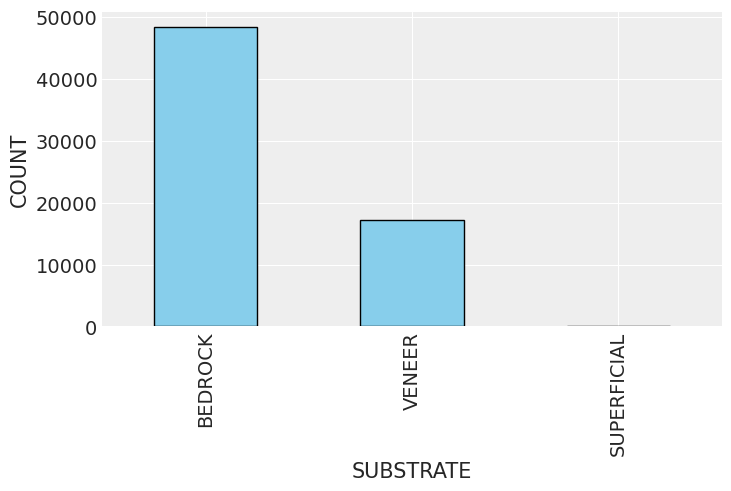

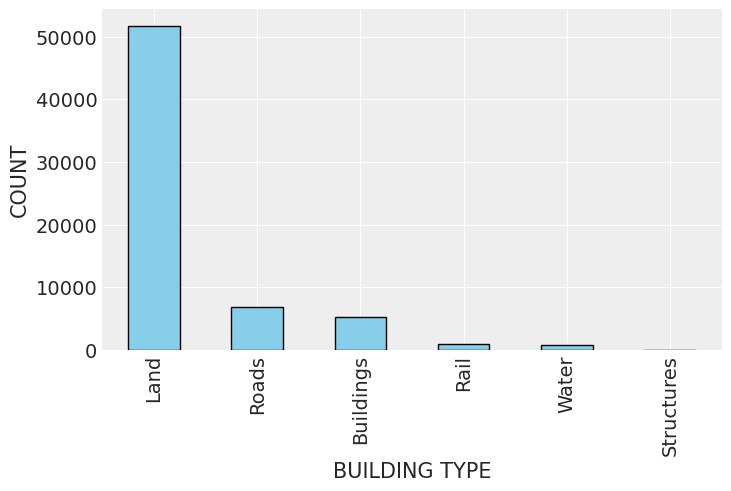

In [13]:
for i in range(len(CATEGORICAL)):
    val_count = X[CATEGORICAL[i]].value_counts(sort=True)
    val_count.index = val_count.index.map(MAPPINGS[i])
    val_count.plot(kind='bar', color="skyblue", edgecolor="black")
    plt.ylabel("COUNT")
    plt.show()

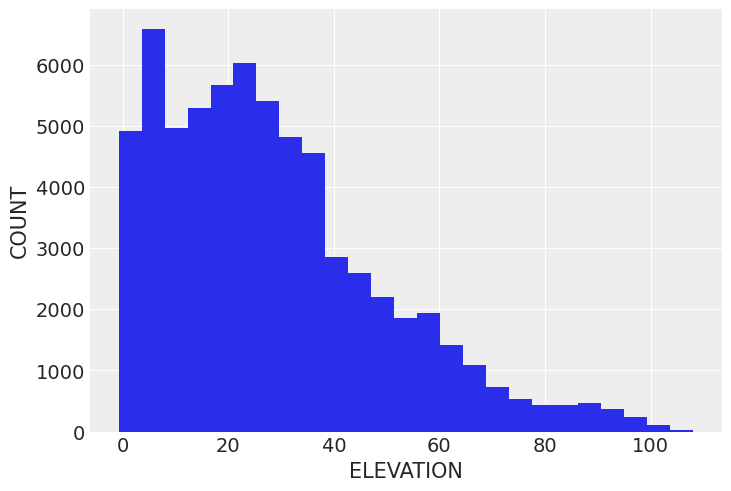

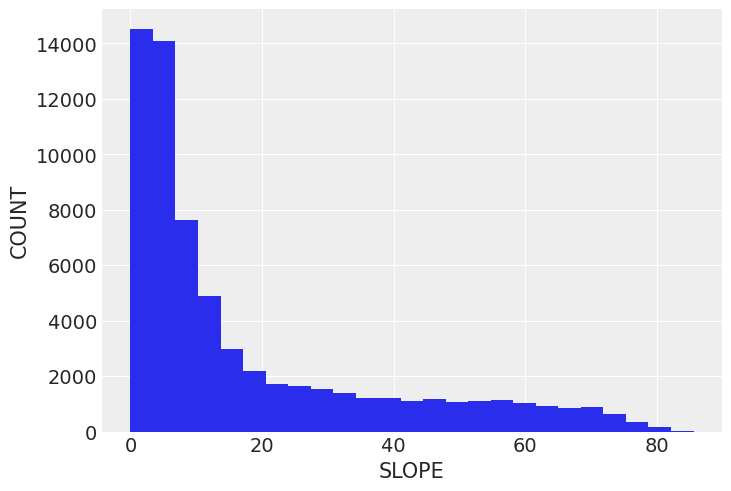

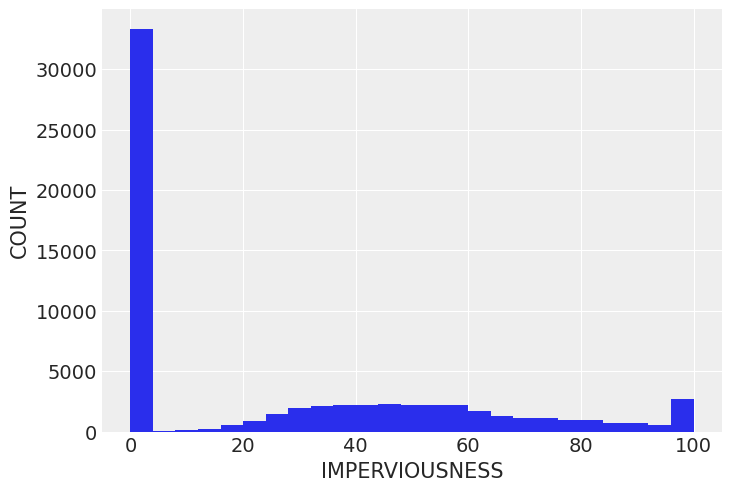

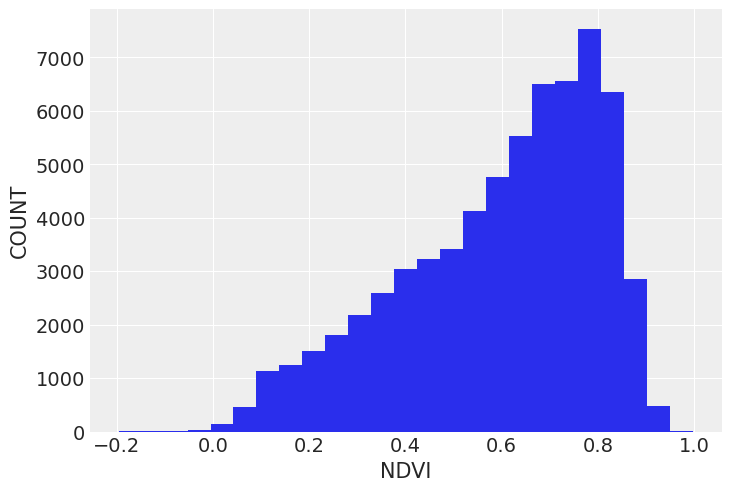

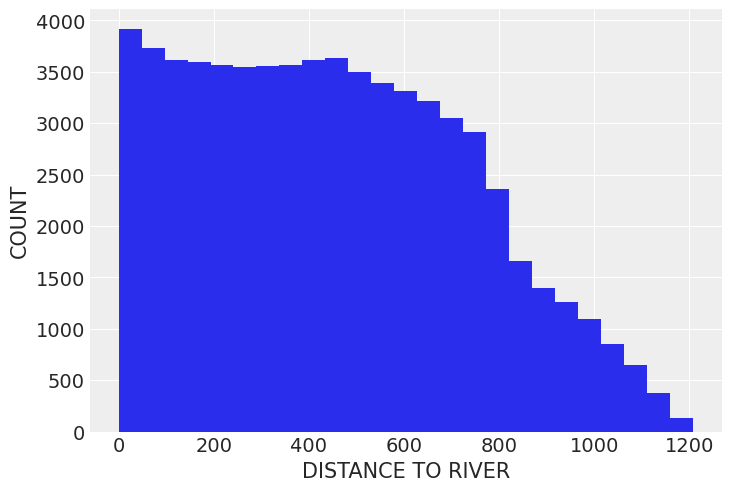

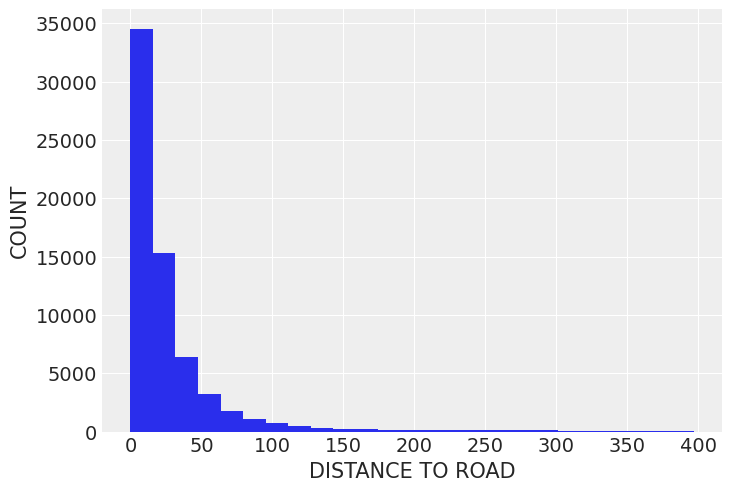

In [14]:
for col in CONTINUOUS:
    plt.hist(X[col], bins = 25)
    plt.xlabel(col)
    plt.ylabel("COUNT")
    plt.show()

### Interpreting the Categorical Data
- SUBSTRATE is an ordinal category; 1 = Bedrock, 2 = Superficial deposit with thin layer, 3 = Superficial deposit - order matters/ bedrock < superficial
- All others are not ordinal so must be OHE
### Interpreting the Continuous Data
- Elevation, slope, and distance to road are logorithmic
- Imperviousness has high number of 0s - more information needed to decide if this should be split into a categorical and continuous feature (i.e. if 0 means something) so will keep as is
- Normalise NDVI
- Standardise all

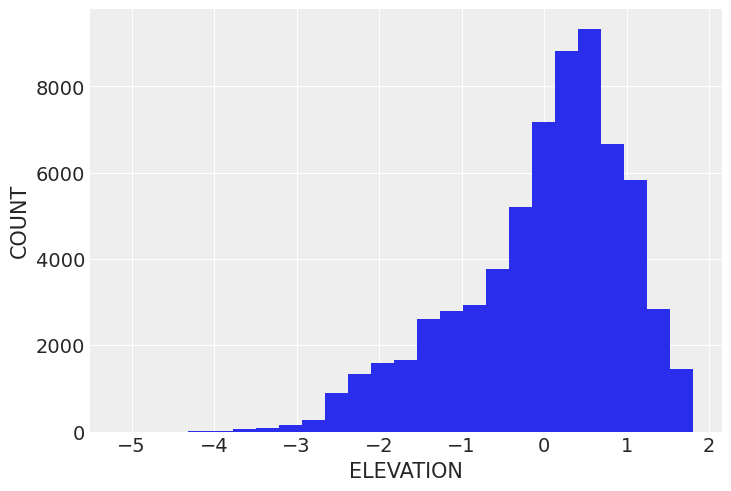

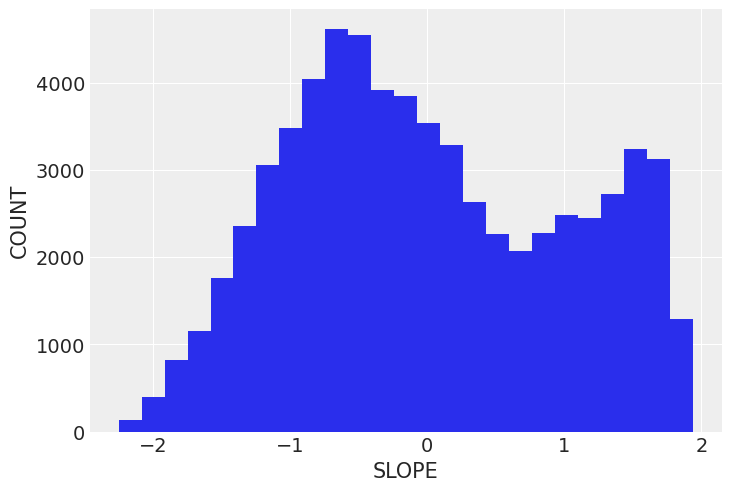

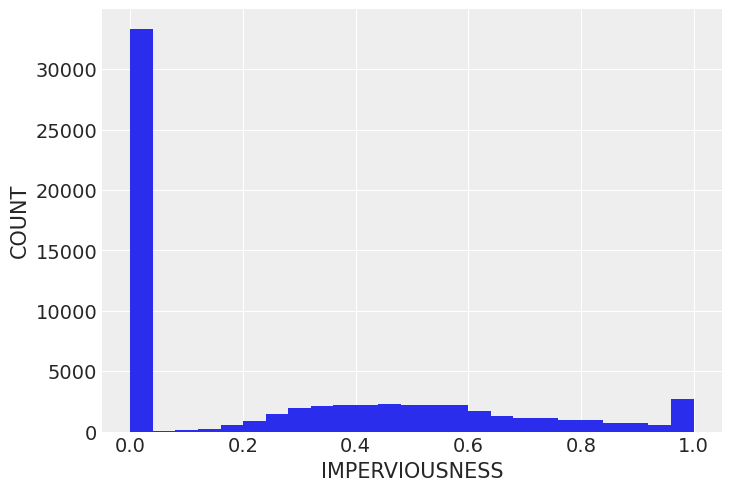

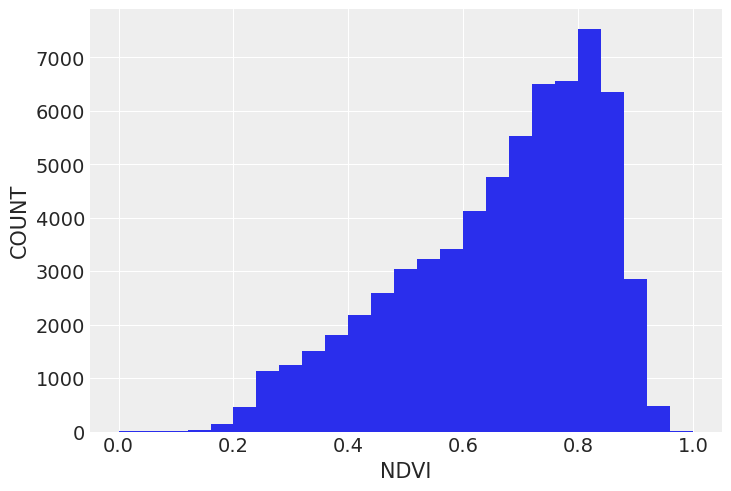

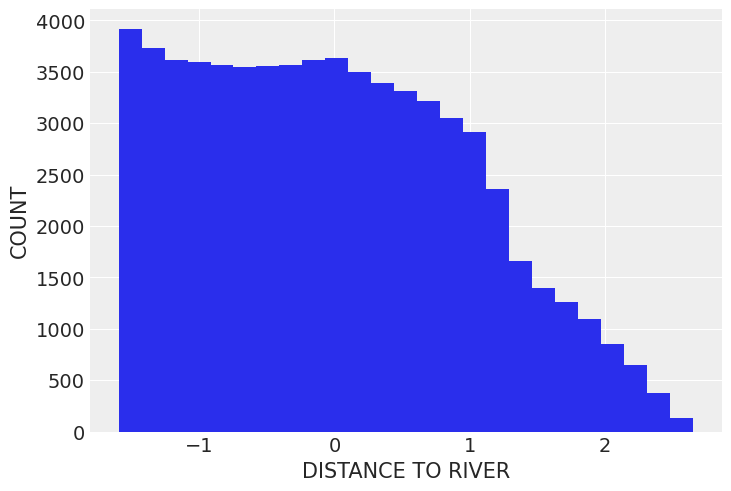

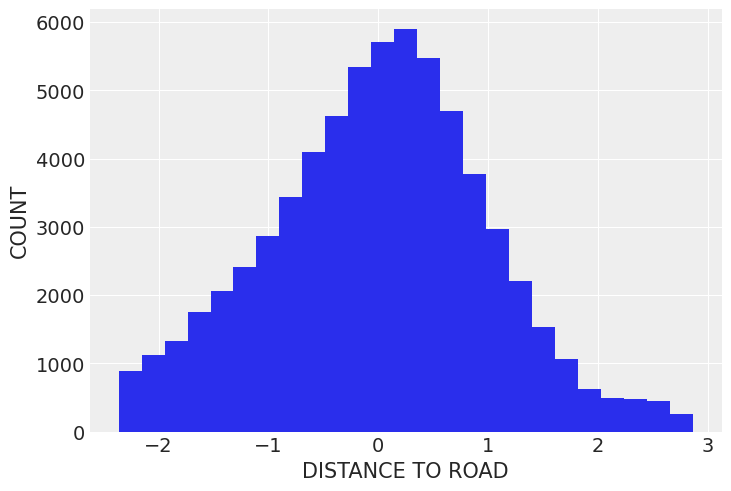

In [15]:
# PREPARE DATA 
LOGORITHMIC = ['ELEVATION','SLOPE', 'DISTANCE TO ROAD']
MIN_MAX = ['IMPERVIOUSNESS', 'NDVI']
STANDARDIZE = list(set(CONTINUOUS) - set(MIN_MAX))
OHE = ["SOIL TYPE", "LANDUSE", "BUILDING TYPE"]

X["NDVI"] = (X["NDVI"] + 1) / 2 # Scales values from [-1,1] to [0,1]

for col in LOGORITHMIC:
    X[col] = np.log1p(X[col])

scalar = MinMaxScaler()
X[MIN_MAX] = scalar.fit_transform(X[MIN_MAX])

scalar = StandardScaler()
X[STANDARDIZE] = scalar.fit_transform(X[STANDARDIZE])

# Apply One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_data = encoder.fit_transform(X[OHE])
# Convert to DataFrame and ensure index matches X
encoded_data = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(OHE), index=X.index)  # ✅ Fix index
X = pd.concat([X.drop(columns=OHE), encoded_data], axis=1)

for col in CONTINUOUS:
    plt.hist(X[col], bins = 25)
    plt.xlabel(col)
    plt.ylabel("COUNT")
    plt.show()

Output()

Finished [100%]: Average Loss = 26.775


Text(0.5, 0, 'Iteration')

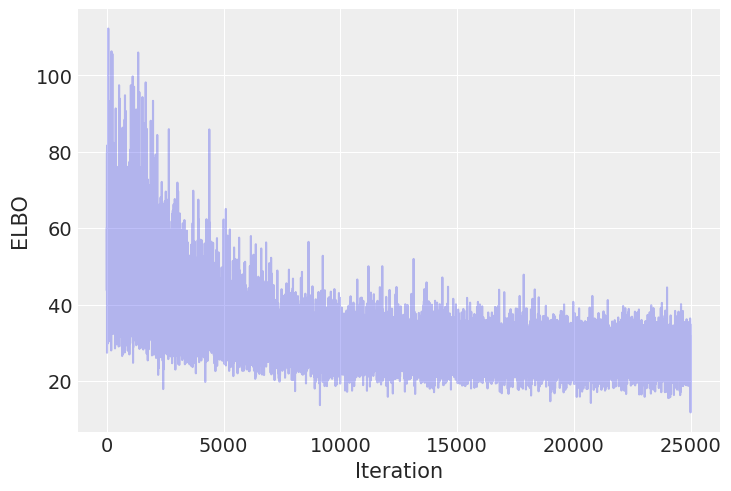

In [16]:
import pymc as pm
from imblearn.under_sampling import RandomUnderSampler 

HIDDEN = [5,5]

Y = Y.clip(0,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

rus = RandomUnderSampler()
X_train, Y_train = rus.fit_resample(X_train, Y_train)

neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN, batch_size=50)

with neural_network:
    approx = pm.fit(n=25000)

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

In [22]:
trace = approx.sample(draws=5000)

ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")


Sampling: [out]


Output()

Test Accuracy: 0.7653


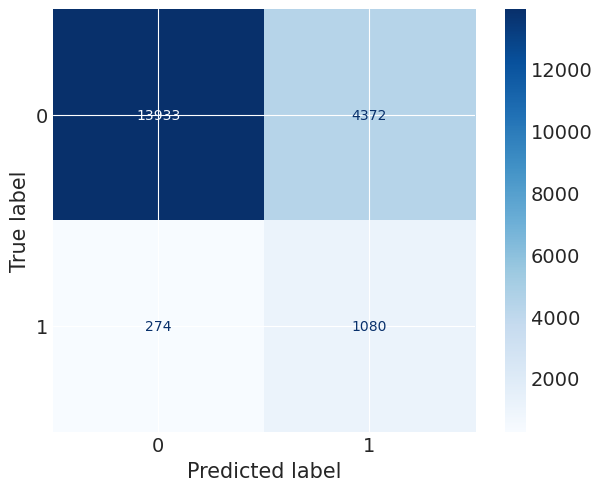

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()

## MCMC

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_0, w_1, w_out]


Output()

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 28 seconds.
/opt/miniconda3/envs/AI_Coursework/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 1895 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/opt/miniconda3/envs/AI_Cours

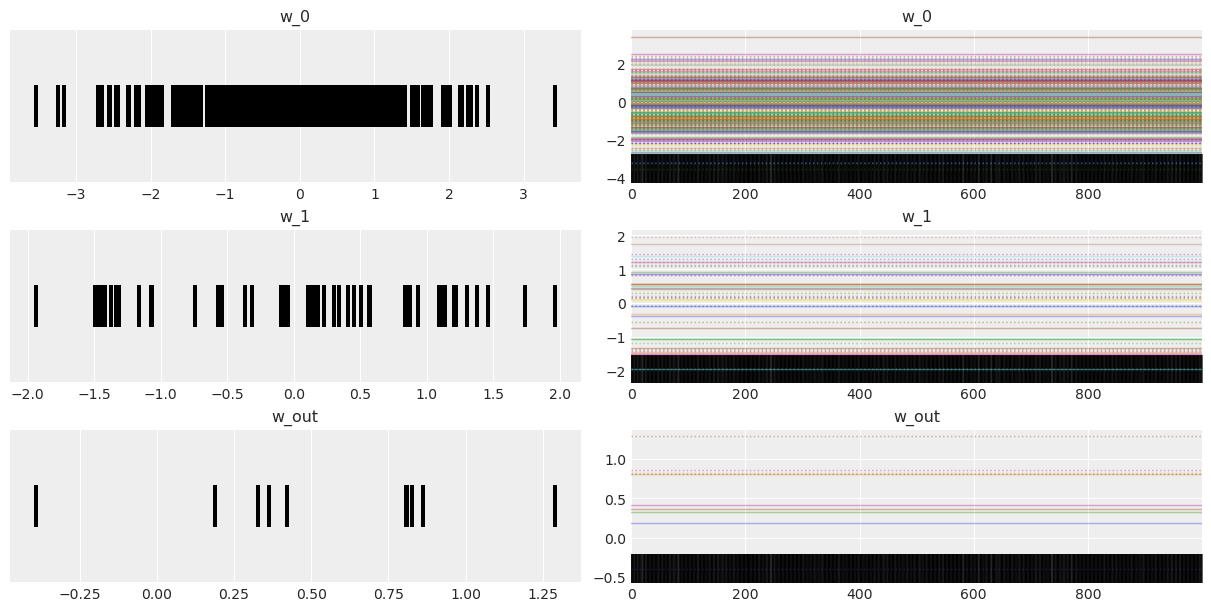

In [21]:
# Construct the neural network model
neural_network = construct_nn(X_train, Y_train, hidden_layers=HIDDEN, batch_size=1)

# Use MCMC instead of Variational Inference
with neural_network:
    trace = pm.sample(
        draws=1000,  # Number of samples
        tune=2000,   # Burn-in period
        chains=2,    # Number of MCMC chains
        target_accept=0.9,  # Helps with step size adaptation
        return_inferencedata=True
    )

# Plot the trace (posterior samples of weights)
pm.plot_trace(trace)
plt.show()

Sampling: [out]


Output()

Test Accuracy: 0.7631


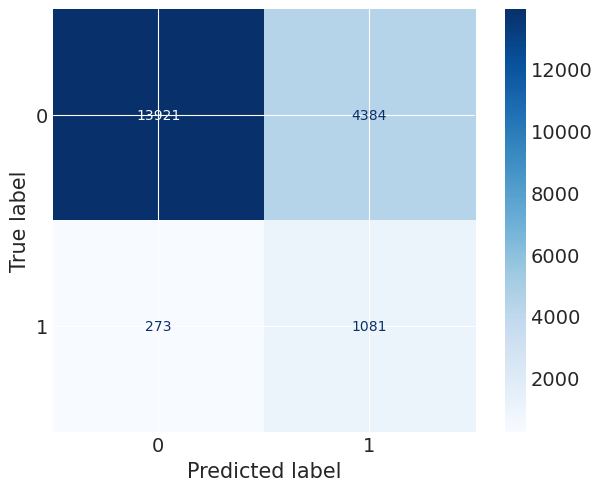

In [ ]:
trace = approx.sample(draws=5000)

ppc = sample_posterior_predictive(X_test, Y_test, trace, hidden_layers=HIDDEN,)

pred = ppc.posterior_predictive["out"].mean(("chain", "draw")).round()
accuracy = accuracy_score(Y_test, pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

# Show the plot
plt.show()